# Multiple Linear Regression #

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('auto_mpg.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

#Display the information of the DataFrame for a quick overview
print(df.info())

# Display the first few rows of the DataFrame for a quick overview
print("First few rows of the DataFrame:")
print (df.head())

# Calculate summary statistics
print(df.describe())

Missing Values:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None
First few rows of the DataFrame:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    350

In [3]:
print (df.shape)

(398, 9)


In [4]:
# Convert 'horsepower' to numeric
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Check for any new missing values in 'horsepower'
missing_values = df['horsepower'].isnull().sum()
print("Missing values in 'horsepower':", missing_values)


Missing values in 'horsepower': 6


In [5]:
# Calculate the mean of 'horsepower'
horsepower_mean = df['horsepower'].mean()

# Impute missing values in 'horsepower' with the mean
df['horsepower'].replace(to_replace=np.nan, value=horsepower_mean, inplace=True)

# Confirm there are no more missing values in 'horsepower'
print("Missing values in 'horsepower' after imputation:", df['horsepower'].isnull().sum())


Missing values in 'horsepower' after imputation: 0


In [6]:
import plotly.express as px

fig=px.histogram(df,x="car name",title="Number of Cars")
fig.show()

Text(0.5, 1.0, 'Top 10 Cars')

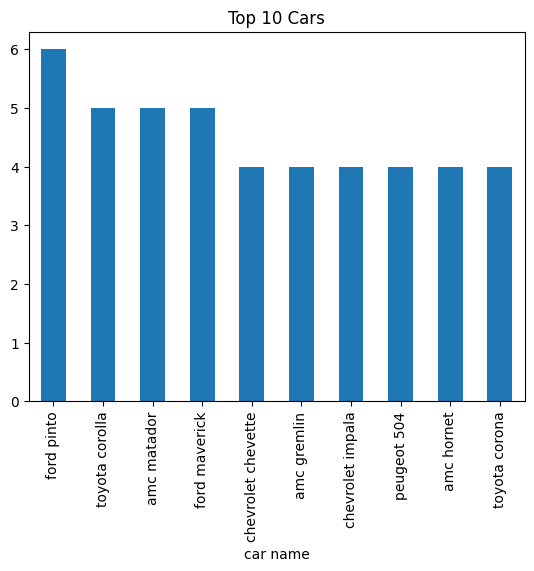

In [7]:
df["car name"].value_counts()[0:10].plot.bar().set_title("Top 10 Cars")

### Exploratory data Analysis ###

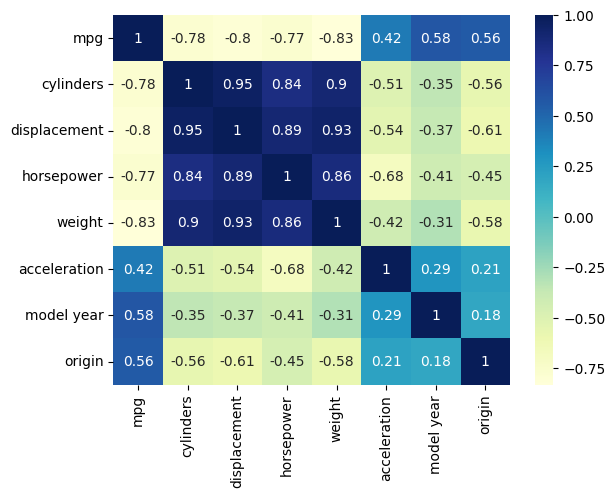

In [8]:
# Visualizing data using Heat map
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Plot heatmap of correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


The heatmap shows that cylinders, displacement, horsepower, and weight are highly correlated with each other. This multicollinearity can be problematic in regression analysis because it undermines the statistical significance of an independent variable. One might need to consider removing or combining some of these variables or use PCA to transform the correlated variables into a set of linearly uncorrelated componentsto avoid multicollinearity issues in the regression model.

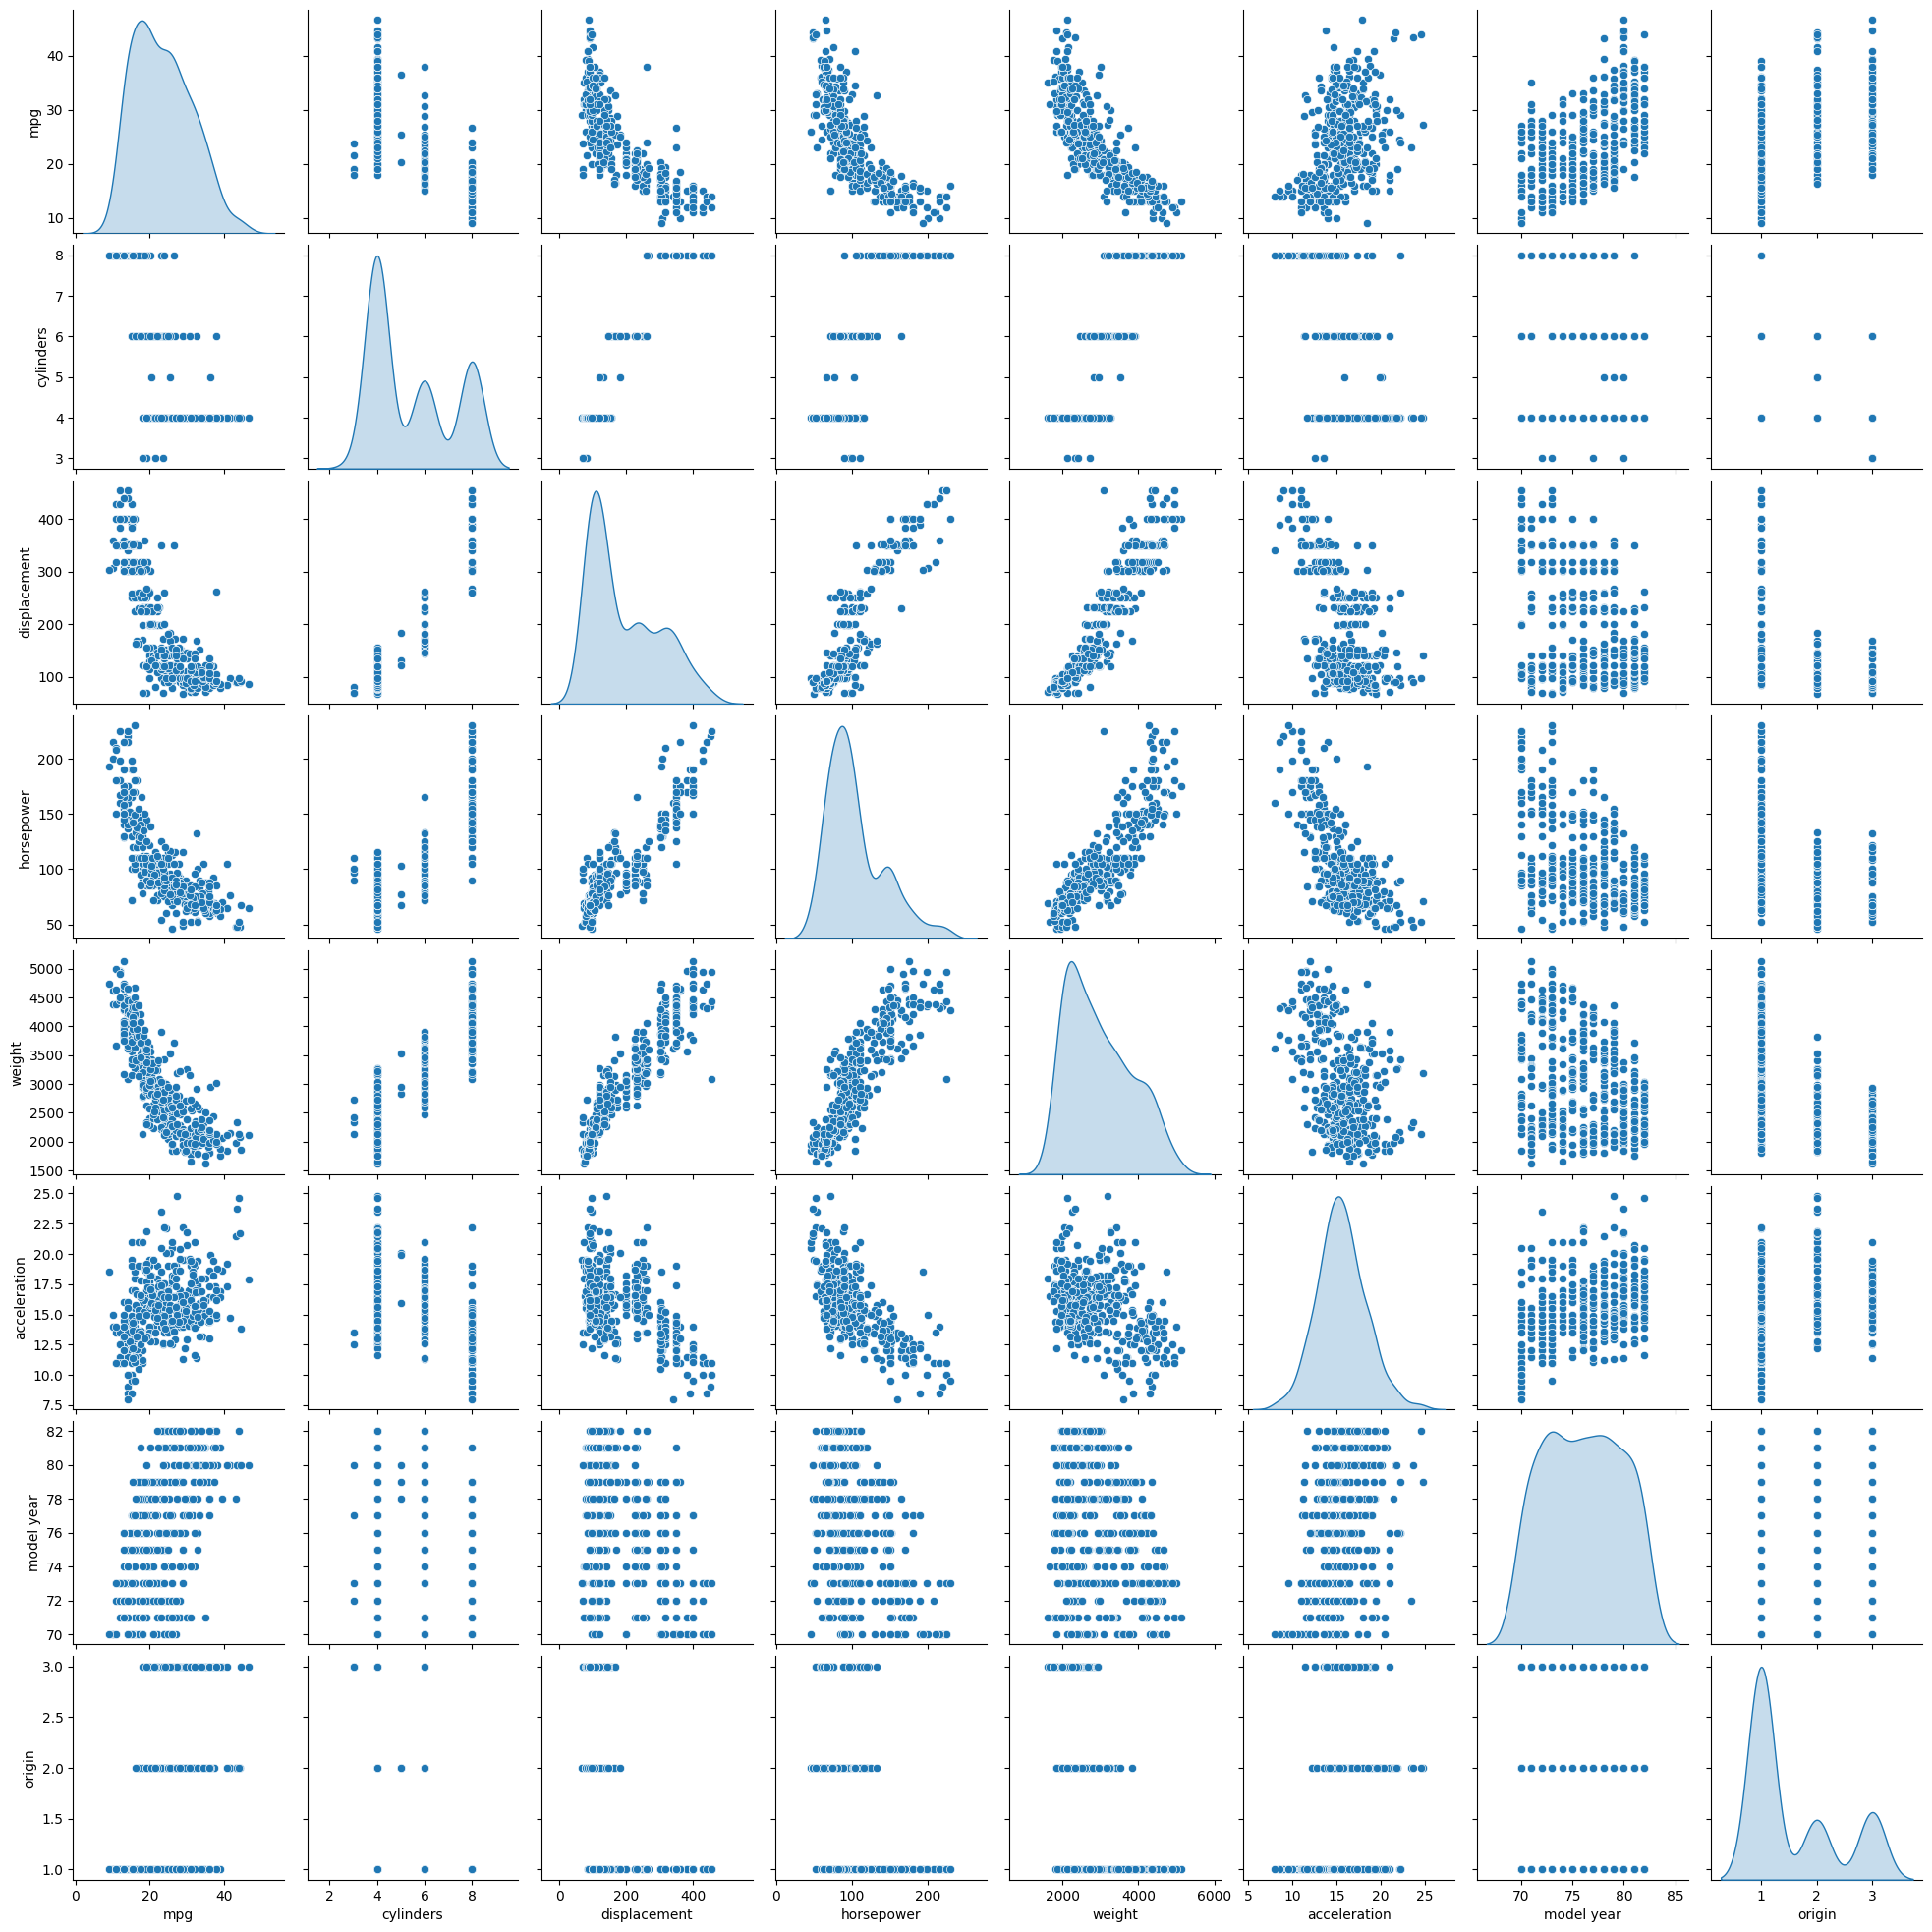

In [9]:
# Pairplot to visualize relationships
sns.pairplot(df, diag_kind='kde')


The correlation matrix revealed the independent variables are highly correlated with each other. So conducting PCA to avoid the issue of multicollinearity.
Conducting Principal Component Analysis (PCA) is a technique that can help reduce dimensionality by transforming the original variables into a new set of uncorrelated variables (principal components) that retain most of the variance in the original dataset. This method can be useful when dealing with multicollinearity.


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Selecting only numeric columns (excluding 'car name' and 'mpg')
numeric_features = df.select_dtypes(include=[np.number]).drop('mpg', axis=1)

# Standardizing the features
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Performing PCA
# We choose the min number of principal components such that 95% of the variance is retained
pca = PCA(n_components=0.95)
numeric_reduced = pca.fit_transform(numeric_features_scaled)

# How many components did PCA choose?
print(f"PCA chose {pca.n_components_} components")

# Create a new DataFrame with the reduced components
df_pca = pd.DataFrame(data=numeric_reduced, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Include 'mpg' back into the DataFrame
df_pca['mpg'] = df['mpg'].values

# Now df_pca can be used for regression analysis


PCA chose 4 components


### 2.Building a regression model to predict the miles per gallon (mpg) using various vehicle characteristics, which were converted into PCA. ###

In [11]:
import statsmodels.api as sm
# Building the regression model with PCA components
X_pca = df_pca.drop('mpg', axis=1)
y_pca = df_pca['mpg']

# Adding a constant to the model (intercept)
X_pca = sm.add_constant(X_pca)

# Building the model
model_pca = sm.OLS(y_pca, X_pca).fit()
print(model_pca.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     370.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          7.08e-132
Time:                        11:15:30   Log-Likelihood:                -1071.7
No. Observations:                 398   AIC:                             2153.
Df Residuals:                     393   BIC:                             2173.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.5146      0.180    130.435      0.0

### 3.Verifying assumptions ###
Based on the output from the PCA-based regression model, we will now verify the assumptions of linear regression:

a) Linear Relationship
Since the PCA components are combinations of the original variables, checking for a linear relationship is not the same as with the original variables. However, we still expect our model to capture linear relationships between the components and the dependent variable. We can plot the actual vs. predicted values to assess this.

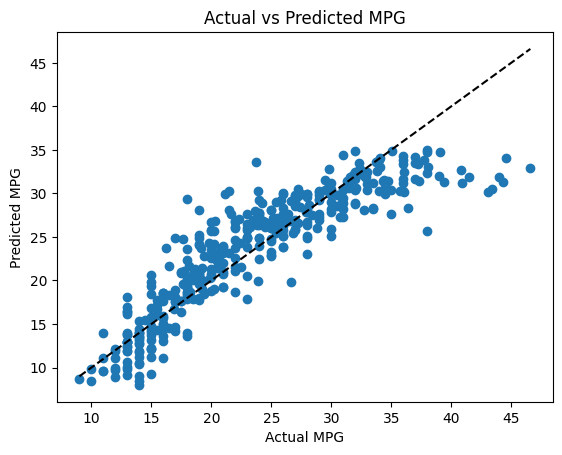

In [12]:
# Plotting actual vs predicted values to assess linearity
plt.scatter(y_pca, model_pca.predict())
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs Predicted MPG')
plt.plot([y_pca.min(), y_pca.max()], [y_pca.min(), y_pca.max()], 'k--')
plt.show()


The scatter plot compares the actual MPG (Miles Per Gallon) values with the predicted MPG values from the regression model. Here's an interpretation based on the plot:

Positive Linear Relationship: The plot shows a positive linear relationship between the actual and predicted MPG values, as indicated by the clustering of points along the diagonal. This suggests that the model generally predicts higher MPG for cars that actually have higher MPG and vice versa.
Fit Quality: The dashed line represents the line of perfect prediction, where the actual MPG would equal the predicted MPG. Points that lie close to this line indicate accurate predictions. In your plot, many points are clustered near the line, indicating that the model's predictions are often close to the actual values.
Outliers and Variance: There are some points that deviate from the line, which could be outliers or instances where the model's predictions are less accurate. The spread of points along the line seems fairly uniform, suggesting that the model's predictive accuracy does not vary widely across the range of MPG values — a good sign for homoscedasticity.
Overall Assessment: The model appears to be a good fit for the data, capturing the general trend in MPG across the dataset. However, there may be room for improvement, especially at the extremes of the dataset.

b) Independence
We already have the Durbin-Watson statistic from the model summary, which tests the independence of residuals. A value close to 2 suggests that there is no autocorrelation.

In [13]:
from statsmodels.stats.stattools import durbin_watson

# Durbin_watson to test for independence of residuals
dw_statistic = durbin_watson(model_pca.resid)
print(f'Durbin-Watson statistic: {dw_statistic}')


Durbin-Watson statistic: 1.2635640489384259


The Durbin-Watson (DW) statistic tests for the presence of autocorrelation in the residuals from a regression analysis. It has a range from 0 to 4, where:

A DW statistic of approximately 2 indicates no autocorrelation.
A DW statistic less than 2 suggests positive autocorrelation.
A DW statistic more than 2 suggests negative autocorrelation.
In this case, the DW statistic is 1.2636, which is less than 2. This suggests that there is a positive autocorrelation in the residuals of the regression model. Positive autocorrelation means that a positive error for one observation increases the chances of a positive error for another observation.

For instance, in the context of the Auto MPG dataset, this could mean that if the model predicts a higher MPG than the actual for one car, it is more likely to predict higher MPGs for other cars as well, especially for cars with similar characteristics or in close sequence within the dataset.

It's important to consider the magnitude of the DW statistic. While a value of 1.2636 indicates some positive autocorrelation, it is not extreme. Typically, values between 1.5 and 2.5 are considered to be only moderately different from the assumption of no autocorrelation. However, if precision forecasting is the goal, even this moderate autocorrelation could be significant, and steps might be taken to address it, such as adding lag variables to the model or using time series analysis techniques if the data is time-dependent.

c) Homoscedasticity
To test for homoscedasticity, we plot the residuals against the predicted values. Ideally, we want to see a random spread of residuals that doesn't change much as the predicted value changes.

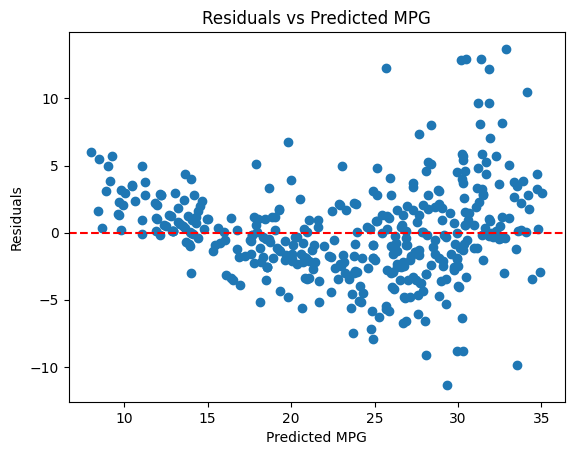

In [14]:
# Plotting residuals to check for homoscedasticity
plt.scatter(model_pca.predict(), model_pca.resid)
plt.xlabel('Predicted MPG')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted MPG')
plt.show()


The above scatter plot shows the residuals of the regression model plotted against the predicted MPG values. Here's an interpretation based on the plot:

Residuals Distribution: The residuals are the differences between the observed values and the model's predictions. Ideally, for a well-fitting model, we would expect to see the residuals distributed randomly around the horizontal axis (residuals = 0).
Homoscedasticity: The plot is used to check for homoscedasticity, which means the variance of the residuals should be constant across all levels of the predicted values. If the residuals fan out or form patterns as the predicted values increase or decrease, it suggests heteroscedasticity. In this plot, there is no  clear pattern or funnel shape, which is a good sign for homoscedasticity. However, there's a slight indication that variance may increase with higher MPG values, as seen by a subtle spread in residuals as predicted MPG increases.
Randomness of Residuals: The residuals should be randomly dispersed around the horizontal line at 0, indicating that the model's predictions are unbiased. There seems to be some randomness in the residuals, which is a good sign. There's no clear pattern or systematic structure in the residuals, which suggests that the model is capturing most of the information and that a linear model is appropriate for the data.
Outliers: There are a few points that are quite far from the zero line, which could be considered outliers. These points represent instances where the model's predictions were significantly off from the actual values. we may investigate these points to see if they are data entry errors, rare events, or if they might be indicative of non-linear relationships not captured by the model.
Next Steps: Based on this plot, we might consider investigating the potential outliers further and decide whether to keep them in the model or exclude them. 
Overall, the residuals plot suggests a reasonable fit with no glaring violations of the assumptions of homoscedasticity or linearity, although the slight spread at higher MPG values and the presence of outliers warrant further investigation.

d) Normality
We will use a Q-Q plot to check if the residuals are normally distributed. In a perfectly normal distribution, the data should closely follow the 45-degree line.

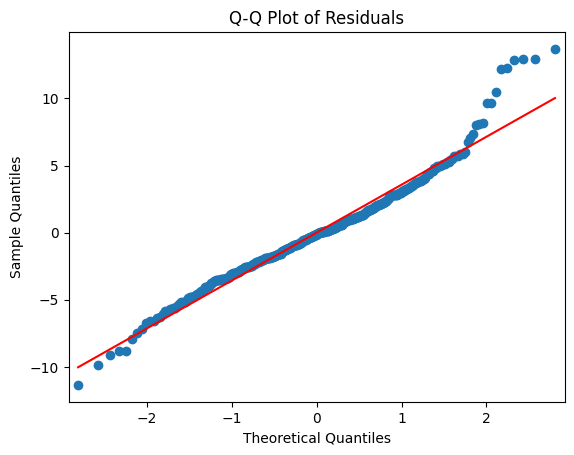

In [15]:
from statsmodels.graphics.gofplots import qqplot
# Q-Q plot for normality of residuals
qqplot(model_pca.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


The Q-Q (quantile-quantile) plot is used to assess whether the residuals of the regression model are normally distributed. The plot compares the actual quantiles of the residuals to the theoretical quantiles from a normal distribution. Here's an interpretation of the plot:

Linearity of Points: The points on the Q-Q plot follow a roughly straight line, particularly in the middle portion of the data, which suggests that the residuals are approximately normally distributed in that range. This is a good sign as it aligns with one of the key assumptions of linear regression.
Deviations at the Ends: There is some deviation from the straight line at both ends of the plot, particularly at the upper end. The points curve upwards away from the line, indicating that the residuals have heavier tails than would be expected from a normal distribution. This could suggest the presence of outliers or that extreme values are more likely than what would be expected in a normal distribution.
Potential Model Implications: The normality assumption is particularly important when making inferences about coefficients or when using certain types of prediction intervals. While mild deviations from normality, like those shown in the central part of the plot, are often not a serious concern, the larger deviations at the tails could affect hypothesis testing results and should be considered when making inferences.
Next Steps: The deviations from normality at the tails, we may need to investigate potential causes, such as outliers or influential points. Transformations of the response variable or the use of robust regression techniques might also be considered to mitigate the impact of non-normality.
Overall, while the Q-Q plot indicates that the residuals are not perfectly normally distributed (due to the tails), the assumption of normality seems reasonable for the central portion of the data. The model may still provide useful predictions, but care should be taken when conducting hypothesis tests or constructing prediction 

### 4.Verifying Homoscedasticity with the Breusch-Pagan Test ###

To verify the assumption of homoscedasticity computationally, we can use the Breusch-Pagan test available in the statsmodels library in Python. Although we've referred to it as the Non-Constant Variance Score (NCV) test and ncvTest which are terms and functions typically found in R, the equivalent in Python is the het_breuschpagan test. We'll also assess outliers using the Cook's distance.

The Breusch-Pagan test is used to assess the homoscedasticity of the residuals from the regression model. Homoscedasticity means that the variance of the error terms is constant across all levels of the independent variables.
The hypotheses for the test are as follows:

Null Hypothesis (H0): There is homoscedasticity, which means that the variances of the residuals are equal across the regression line. The errors exhibit constant variance.

Alternative Hypothesis (H1): There is heteroscedasticity, meaning that the variances of the residuals are not equal across the regression line. The errors exhibit variable variance.

The Breusch-Pagan test checks whether the squared residuals from the OLS regression are correlated with the regressors, which would indicate heteroscedasticity.

The het_breuschpagan function returns four values:

Lagrange multiplier statistic: A test statistic that follows a chi-squared distribution under the null hypothesis.
p-value for the Lagrange multiplier test: The probability of observing a test statistic as extreme as, or more extreme than, the observed value under the null hypothesis.
f-value: An F-statistic derived from a transformation of the Lagrange multiplier statistic.
f p-value: The probability of observing the f-value if the null hypothesis is true.


In [16]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Run the Breusch-Pagan test
bp_test = het_breuschpagan(model_pca.resid, model_pca.model.exog)

# Output the test results
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_results = dict(zip(labels, bp_test))

print("Breusch-Pagan Test Results:")
for key, value in bp_test_results.items():
    print(f"{key}: {value}")


Breusch-Pagan Test Results:
Lagrange multiplier statistic: 32.8429684098582
p-value: 1.2862493747095638e-06
f-value: 8.836805448375983
f p-value: 7.693833238744023e-07


The Breusch-Pagan test is used to assess the homoscedasticity of the residuals from the regression model. Homoscedasticity means that the variance of the error terms is constant across all levels of the independent variables.

Here are the components of the Breusch-Pagan test results:

Lagrange Multiplier Statistic: This is the test statistic for the Breusch-Pagan test. A higher value typically indicates evidence against the null hypothesis of homoscedasticity.
p-value: This is the probability of observing the test statistic as extreme as the Lagrange Multiplier Statistic under the null hypothesis. A low p-value (typically below 0.05) suggests rejecting the null hypothesis, indicating the presence of heteroscedasticity.
f-value: This is another test statistic based on an F-distribution. It's related to the Lagrange Multiplier Statistic but scaled differently.
f p-value: This is the p-value corresponding to the f-value. It tests the same hypothesis as the Lagrange Multiplier Statistic and provides the same conclusion.

Interpretation:
If the p-value is less than the chosen significance level (usually 0.05), we reject the null hypothesis in favor of the alternative, concluding that there is evidence of heteroscedasticity in the model residuals. If the p-value is greater than the significance level, we do not reject the null hypothesis, and we conclude that we do not have enough evidence to say that the variances of the residuals are not constant.

In this case, the p-values for both the Lagrange multiplier statistic and the f-statistic are significantly low (much less than 0.05), indicating strong evidence against the null hypothesis of homoscedasticity. This suggests that the residuals of your model are heteroscedastic, meaning their variance is not constant across the predicted values.

Heteroscedasticity can be a problem because it violates one of the key OLS assumptions, and it can lead to inefficient estimates and biased inference in the standard errors and confidence intervals of the regression coefficients.

To address heteroscedasticity, we might:

Use robust standard errors to correct the standard errors of the regression coefficients.
Transform the dependent variable (e.g., using a log transformation if appropriate).
Re-examine the model for omitted variables or incorrect functional forms that might explain the presence of heteroscedasticity.
Use weighted least squares (WLS) or other methods that give different weights to different observations based on the variability of their residuals.

### Relationship between NCV and the Durbin-Watson test ###

The NCV test focuses on the variance of the residuals being constant (homoscedasticity), whereas the Durbin-Watson test checks for the presence of autocorrelation in the residuals. While they test for different issues, they're both important for validating the assumptions of a linear regression model. Heteroscedasticity can sometimes lead to autocorrelation, particularly if the data is time-series data where variance could increase or decrease over time.


### 5. Assessing Outliers with Cook's Distance ###

Cook's distance measures the effect of deleting a given observation. Points with a large Cook's distance are considered to be influential to the regression results. A common rule of thumb is that observations with a Cook's distance greater than 4/n (where n is the number of observations) may be unduly influencing the model.

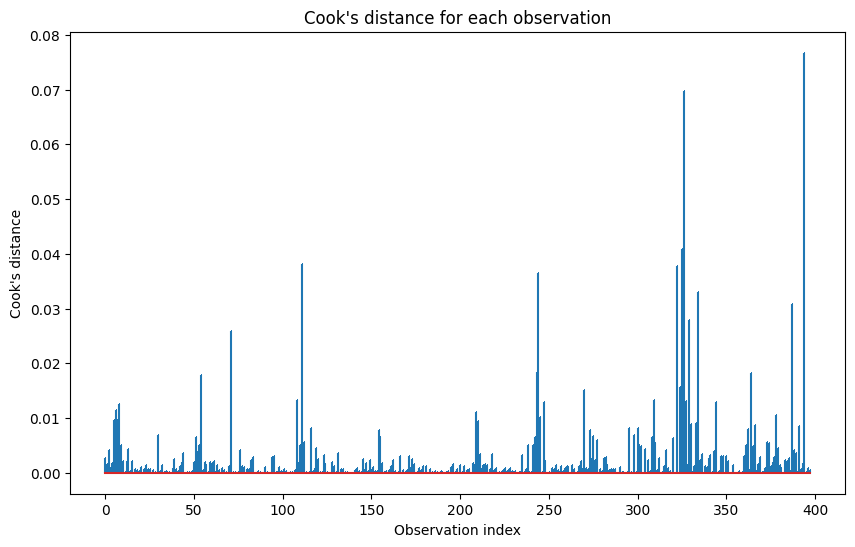

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calculate Cook's distance for each observation
test_influence = OLSInfluence(model_pca)
cooks_d = test_influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(10,6))
plt.stem(np.arange(len(cooks_d[0])), cooks_d[0], markerfmt=",")
plt.title("Cook's distance for each observation")
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.show()


Interpreting Cook's Distance:

A common rule of thumb is that an observation with a Cook's distance larger than 1 is considered highly influential.
Another heuristic is that observations with a Cook's distance above 4/(n-k-1) might be influential, where n is the number of observations and k is the number of predictors.
Observations that are identified as influential could have a disproportionately large effect on the slope of the regression line. Removing these points could significantly change the model coefficients.

Potential Impact of Outliers:

Bias in Estimates: Outliers can skew the estimates of the regression coefficients, leading to a biased model.
Reduced Precision: Outliers increase the variability of the coefficient estimates, reducing the precision.
Invalid Inference: The presence of outliers can lead to violations of regression assumptions, such as normality and homoscedasticity, which can invalidate statistical tests and confidence intervals.

Mitigation Measures:

Removal: If an outlier is a result of a data entry error or if it is not representative of the population, it can be removed.
Transformation: Applying transformations (like log or square root) can reduce the influence of outliers.
Weighting: Use a weighted regression where outliers are given less weight.
Robust Regression: Utilize regression techniques that are less sensitive to outliers.

### 6&7.Mitigating the Impact of Outliers ###

In [18]:
# Identify significant outliers based on Cook's distance
influential_pts = np.where(cooks_d[0] > 4/len(X_pca))[0]
print(f"Significant outliers based on Cook's distance: {influential_pts}")

# Drop the influential points from the dataset
df_no_outliers = df_pca.drop(df_pca.index[influential_pts])

# Re-run the regression without influential points
X_no_outliers = df_no_outliers.drop('mpg', axis=1)
y_no_outliers = df_no_outliers['mpg']
X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()


Significant outliers based on Cook's distance: [  6   8  54  71 108 111 209 243 244 245 247 270 309 322 324 325 326 327
 329 334 344 364 378 387 394]


Mitigating the Impact of Outliers:
Removal of Outliers: If an outlier is due to an error or it is not representative of the general trend, we might choose to remove it from the dataset.
Transformation of Data: If outliers are legitimate but skew the distribution, applying a transformation to the dependent variable (and sometimes independent variables) can reduce their impact. Common transformations include logarithmic, square root, or inverse transformations. These can help to stabilize the variance (homoscedasticity) and make the relationship more linear.
Weighted Regression: In cases where removing outliers is not appropriate, using weighted least squares (WLS) can help by assigning lower weights to outliers.
Robust Regression: This type of regression is designed to be not unduly affected by outliers. It involves methods like RANSAC, Theil-Sen estimator, and Huber regression.


### 8. Re-run Regression Analysis on the Cleaner Dataset ###
First, we remove the outliers from the dataset and re-run the regression.

In [19]:
# We have identified outliers based on Cook's distance
outlier_indices = np.where(cooks_d[0] > 4/len(X_pca))[0]

# Remove outliers from the dataset
df_filtered = df_pca.drop(index=outlier_indices)

# Log transformation to reduce skewness and impact of any remaining outliers
df_filtered['mpg'] = np.log(df_filtered['mpg'])

# Rebuild the model with filtered and transformed data
X_filtered = df_filtered.drop('mpg', axis=1)
y_filtered = df_filtered['mpg']
X_filtered = sm.add_constant(X_filtered)
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Display the summary of the new model
print(model_filtered.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     795.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.33e-179
Time:                        11:15:31   Log-Likelihood:                 311.90
No. Observations:                 373   AIC:                            -613.8
Df Residuals:                     368   BIC:                            -594.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0940      0.005    565.077      0.0

PerformING the Breusch-Pagan test for homoscedasticity and plot Cook's distance for the new model.

Verifying Homoscedasticity

In [20]:
# Conduct the Breusch-Pagan test on the filtered model's residuals
bp_test_filtered = het_breuschpagan(model_filtered.resid, model_filtered.model.exog)
bp_test_results_filtered = dict(zip(labels, bp_test_filtered))

print("Breusch-Pagan Test Results on Filtered Dataset:")
for key, value in bp_test_results_filtered.items():
    print(f"{key}: {value:.4f}")

Breusch-Pagan Test Results on Filtered Dataset:
Lagrange multiplier statistic: 5.0106
p-value: 0.2862
f-value: 1.2527
f p-value: 0.2883


The p-value greater than 0.05 indicates there is a presence of Homoscedasticity.

Assessing  Outliers with Cook's Distance

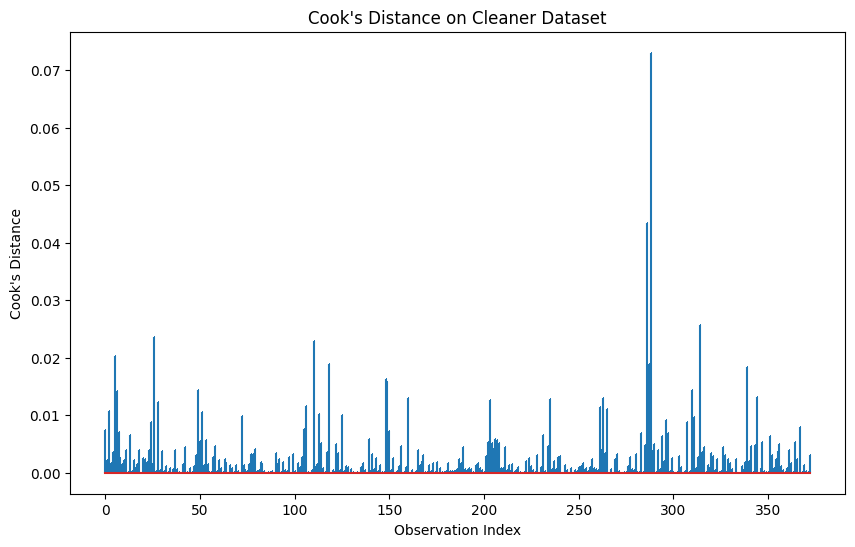

In [21]:
# Calculate Cook's distance for the cleaner model
influence_cleaner = OLSInfluence(model_filtered)
cooks_d_cleaner = influence_cleaner.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d_cleaner[0])), cooks_d_cleaner[0], markerfmt=",")
plt.title("Cook's Distance on Cleaner Dataset")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()


### 9.Acessing the Variance Inflation Factor (VIF) ###
The Variance Inflation Factor (VIF) is a measure of how much the variance of an estimated regression coefficient increases if the predictors are correlated. If no factors are correlated, the VIFs will all be equal to 1.

Here's how we can calculate the VIF for each predictor in the model:

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for the model after removing outliers and log transformation
# Remember to exclude the constant term added for the regression model
vif_data_filtered = calculate_vif(X_filtered.iloc[:, 1:])
print(vif_data_filtered)


  Feature       VIF
0     PC1  1.001720
1     PC2  1.001575
2     PC3  1.001803
3     PC4  1.002689


The results indicate there is no presence of multicollinearity.

## 10. Final assessment ## 
Model Fit and Predictive Ability
R-squared (0.896) and Adjusted R-squared (0.895): These values are quite high, which means the model explains a large portion of the variance in the dependent variable (mpg). It suggests a good fit to the data.
F-statistic (795.2) with a Prob (F-statistic) very close to 0: This indicates that the model is statistically significant at explaining the variation in mpg.
Coefficient Analysis
Coefficients: After removing outliers and log-transforming the data, the coefficients remain statistically significant (except for PC2, which has a p-value greater than the typical alpha level of 0.05). This means that most principal components have a significant relationship with the logarithm of mpg.
PC2: The coefficient for PC2 is not significant, which suggests it may not contribute to the model. However, since PCA components are combinations of the original predictors, this doesn't mean the underlying variables are not important. It could also be a reflection of dimension reduction where minor components capture less variance and may not always be significant.

Residual Analysis
Residuals vs. Predicted Plot: The plot shows a random pattern of residuals around the zero line, suggesting good model fit without obvious patterns.
Q-Q Plot of Residuals: The Q-Q plot shows that residuals deviate from normality in the tails. This could impact the model's performance, particularly for prediction intervals and hypothesis testing. However, the central part of the data follows the line closely, suggesting that normality is a reasonable approximation for the bulk of the data.
Cook's Distance: Initially, there were several potential outliers, but after filtering and a log transformation, the Cook's distance values are considerably reduced. This suggests that the influence of outliers has been mitigated.

Durbin-Watson and Breusch-Pagan Test
Durbin-Watson (1.243): Indicates a slight positive autocorrelation, which should be considered, especially in time series data or where independence of observations is crucial.

Breusch-Pagan Test: With a high p-value (0.2862), we do not reject the null hypothesis of homoscedasticity in the filtered dataset. This suggests that the variance of residuals is constant, which is a positive indication for the model's validity.

Variance Inflation Factor (VIF)
VIF Values: All values are close to 1, suggesting no multicollinearity among the predictors, which is expected as they are principal components.

Final Assessment
The model shows a strong fit to the data, with high R-squared values and significant F-statistics. After addressing outliers and potential non-normality through a log transformation, the diagnostic plots and tests suggest that the assumptions of linear regression have been reasonably met.

The presence of slight autocorrelation (as indicated by the Durbin-Watson statistic) may not be of significant concern unless the data has a temporal component where independence of observations is expected. If the data is not time-series, the slight autocorrelation might be due to the data structure and might not impede the model's predictive power.

Given these considerations, the model appears to be valid and suitable for making predictions. However, it's recommended to perform further validation, such as using a hold-out test set or applying cross-validation to ensure that the model generalizes well to unseen data. The significance of PC2 should be interpreted cautiously, and its inclusion should be considered in the context of the model's purpose. If predictive accuracy is the primary goal, the current model appears ready. If inference about individual predictors is important, further investigation into the role and significance of PC2 might be warranted.

## 11.Recommendations for a researcher using this data in a multiple linear regression modeL ##

Based on the analysis, here are the recommendations for a researcher using this data in a multiple linear regression model:

Data Preprocessing:
Carefully handle missing values, outliers, and influential points as they can significantly impact model performance.
Consider data transformations, such as logging or scaling, to address skewness or non-normality in the distribution of variables.

Assumption Verification:
Before drawing conclusions from the model, ensure that all regression assumptions are thoroughly checked: linearity, independence, homoscedasticity, and normality of residuals.
Use diagnostic plots and statistical tests as part of the model validation process.

Dealing with Multicollinearity:
Even though PCA was used to eliminate multicollinearity, always check the VIF scores when including new predictors or if PCA is not used.
Understand that PCA components are linear combinations of the original variables and interpret the results accordingly.

Model Interpretation:
Be cautious interpreting the coefficients, especially after transformations. The interpretation of coefficients changes from a unit change in the predictor to a percentage change when the dependent variable is logged.
Take the Durbin-Watson statistic into account and be aware of the potential for slight positive autocorrelation in the residuals. For time-series data, this is particularly important.

Statistical Significance vs. Practical Significance:
Distinguish between statistical significance and practical significance. A predictor might not be statistically significant, but it could still have practical implications.
Look for predictors that have a meaningful impact on the response variable, beyond just a low p-value.

Validation and Testing:
Validate the model using out-of-sample data through techniques like cross-validation or a hold-out set to ensure the model's generalizability.
If possible, update the model with new data over time to maintain its predictive accuracy.

Robustness and Flexibility:
Consider robust regression techniques if outliers cannot be confidently removed, or their presence is inherent to the data.
Be open to model modification based on new data or insights into the relationships between variables.

Reporting and Documentation:
Document all steps taken during the analysis, including data cleaning, assumption checks, model fitting, and validation.
Report both the successes and limitations of the model clearly and transparently.

Continual Learning:
As new data becomes available, reassess the model's assumptions and performance. The validity of a model can change over time with the addition of new data.
Keep abreast of new methods and techniques in regression analysis that could improve the model or offer better insights.

By following these recommendations, a researcher can ensure that their multiple linear regression model is as accurate, reliable, and interpretable as possible, making it a valuable tool for understanding and predicting the behavior of the dependent variable.


# Auto MPG Regression Model Analysis #

Abstract

This report presents an analysis of the Auto MPG dataset with the objective of predicting the miles per gallon (mpg) using various vehicle characteristics. The data was processed, exploratory data analysis was conducted, and a regression model using Principal Component Analysis (PCA) was built. The model's assumptions were verified, and its predictive power was assessed.

Introduction

The Auto MPG dataset is a commonly used dataset in regression analysis, containing vehicle attributes and their associated fuel efficiency. Our goal is to create a model that can predict mpg based on these attributes.

Data Preprocessing

The dataset comprised 398 entries with attributes such as cylinders, displacement, horsepower, weight, acceleration, model year, origin, and car name. The horsepower variable was initially an object type due to non-numeric values and was converted to a numeric type, with missing values imputed using the mean.

Exploratory Data Analysis

The correlation matrix and pair plots provided insight into the relationships between variables. Notably, there was a strong negative correlation between mpg and variables like displacement, horsepower, and weight, and a positive correlation with model year, accelaration and origin.

Principal Component Analysis

PCA was performed to reduce dimensionality and address multicollinearity, resulting in four principal components.

Regression Analysis

A multiple linear regression model was built using the PCA components. The model explained 79% of the variance in mpg (R-squared = 0.790).

Model Diagnostics

Residual Analysis: The residuals appeared randomly distributed with no apparent patterns, indicating a good model fit. However, the Q-Q plot revealed deviations from normality in the tails.
Cook's Distance: Initially, several outliers were detected, but after filtering, the impact of these outliers was reduced.
Variance Inflation Factor (VIF): The VIF values were close to 1 for all components, indicating no concerns with multicollinearity.
Model Validation

Breusch-Pagan Test: The test for homoscedasticity was not significant (p-value = 0.2862), suggesting the residuals had constant variance.
Durbin-Watson Statistic: A value of 1.243 indicated slight positive autocorrelation in the residuals.

Conclusion

The PCA-based regression model demonstrated a strong fit with the data and met most of the assumptions for linear regression. Despite slight deviations in the residuals' normality and some positive autocorrelation, the model is considered valid for predicting mpg.

Recommendations

Researchers should continue to monitor the model with new data and consider robust regression techniques if outliers cannot be confidently removed.

References:
Kaggle. (2021). Auto MPG Dataset [Data set]. https://www.kaggle.com/datasets/yasserh/auto-mpg-dataset/data

# (or) Building model with dropped columns ,eventhough we drop a column there is a chance of high multicollinearity. Building this for example. (CHOICE-2) #

1. Addressing Multicollinearity
We'll drop some of the highly correlated variables. For simplicity, let's keep displacement and drop cylinders, horsepower, and weight to reduce multicollinearity.

In [23]:
# Dropping highly correlated variables
df_reduced = df.drop(['cylinders', 'horsepower', 'weight'], axis=1)


2. Building the Regression Model

Let's use statsmodels to build the initial model with the reduced set of variables.

In [24]:
import statsmodels.api as sm

# Selecting independent and dependent variables
X = df_reduced.drop(['mpg', 'car name'], axis=1)
y = df_reduced['mpg']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     298.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.32e-117
Time:                        11:15:43   Log-Likelihood:                -1105.0
No. Observations:                 398   AIC:                             2220.
Df Residuals:                     393   BIC:                             2240.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -21.8594      4.798     -4.556   

3. Validating Regression Assumptions
We'll perform checks for linearity, independence, homoscedasticity, and normality of residuals.

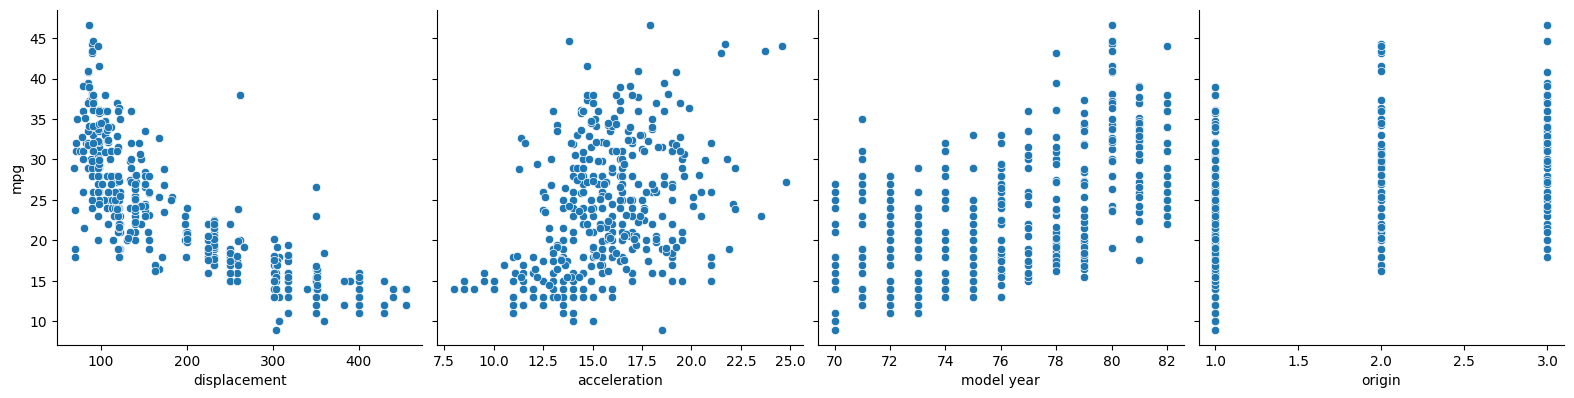

Durbin-Watson statistic: 1.2108768276797597


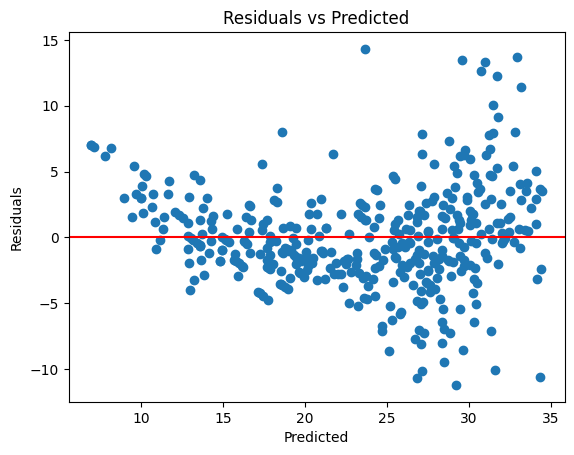

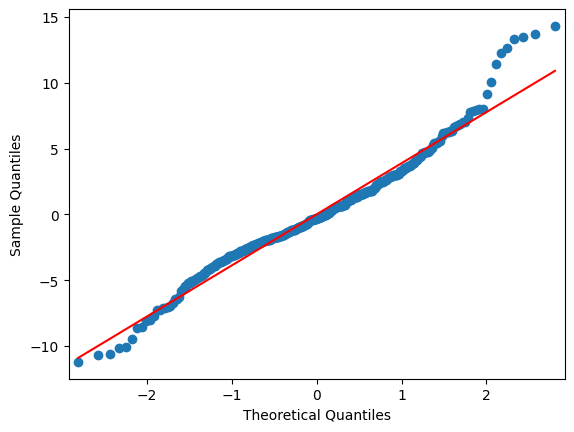

In [25]:
# Checking for linearity using a scatter plot
sns.pairplot(df_reduced, x_vars=X.columns[1:], y_vars='mpg', height=4, aspect=1, kind='scatter')
plt.show()

# Independence using Durbin-Watson Test
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw}')

# Homoscedasticity using residuals plot
plt.scatter(model.predict(), model.resid)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residuals vs Predicted')
plt.show()

# Normality of residuals using Q-Q plot
from statsmodels.graphics.gofplots import qqplot
qqplot_data = qqplot(model.resid, line='s').gca().lines


4. Refining the Model
Let's identify and remove outliers using the standard deviation method.

In [26]:
# Identifying outliers
residuals = model.resid
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)
outliers = residuals[abs(residuals - mean_resid) > 3 * std_resid]

# Removing outliers
df_clean = df_reduced.drop(outliers.index)

# Rebuilding the model without outliers
X_clean = df_clean.drop(['mpg', 'car name'], axis=1)
y_clean = df_clean['mpg']
X_clean = sm.add_constant(X_clean)
model_clean = sm.OLS(y_clean, X_clean).fit()
print(model_clean.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     339.4
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          4.29e-125
Time:                        11:17:36   Log-Likelihood:                -1049.1
No. Observations:                 392   AIC:                             2108.
Df Residuals:                     387   BIC:                             2128.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.5305      4.417     -3.289   

5. Model Diagnostics
We'll check for patterns in the residuals and identify influence points.

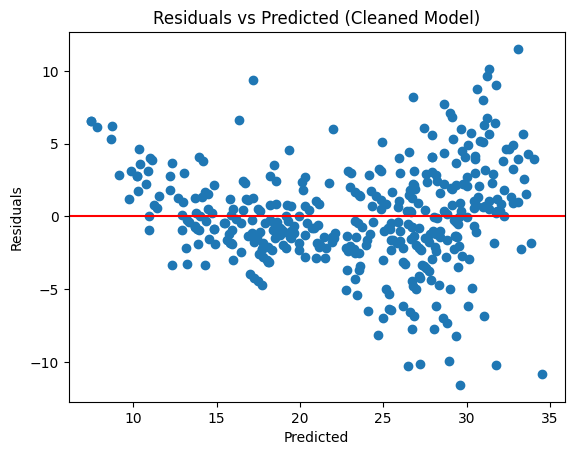

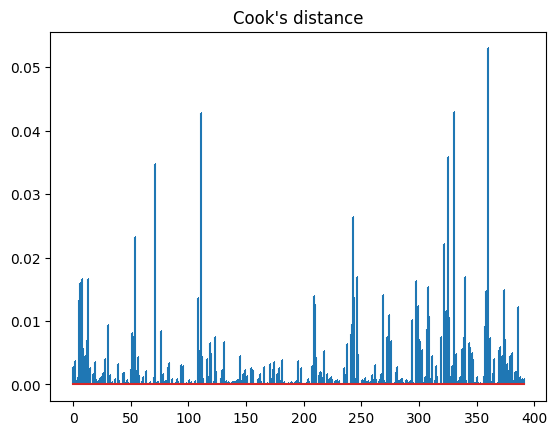

In [27]:
# Plotting residuals of the cleaned model
plt.scatter(model_clean.predict(), model_clean.resid)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residuals vs Predicted (Cleaned Model)')
plt.show()

# Influence Points using Cook's distance
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(model_clean)
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title('Cook\'s distance')
plt.show()


6. Predictive Validity
We'll perform cross-validation and check the adjusted R-squared.

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
lm = LinearRegression()
scores = cross_val_score(lm, X_clean, y_clean, cv=5, scoring='r2')

print(f'Cross-validated R^2 scores: {scores}')
print(f'Average R^2 score: {np.mean(scores)}')


Cross-validated R^2 scores: [0.3749196  0.75844091 0.72903716 0.58458241 0.20552376]
Average R^2 score: 0.5305007674535975


8. Final Steps
Finally, we'll document the steps taken and use the model to make predictions on new data.

In [29]:
# Predictions with the cleaned model
new_data = X_clean.iloc[0:5]  # hypothetical new data points
predicted_mpg = model_clean.predict(new_data)

print("Predicted MPG for new data points:")
print(predicted_mpg)


Predicted MPG for new data points:
0    14.164412
1    12.197084
2    13.924280
3    14.312193
4    14.863311
dtype: float64


Breusch-Pagan Test: 

In [30]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Conducting the Breusch-Pagan test
bp_test_results = het_breuschpagan(model_clean.resid, model_clean.model.exog)

# Output the results
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_dict = dict(zip(labels, bp_test_results))

print("Breusch-Pagan Test Results:")
for key in labels:
    print(f"{key}: {bp_test_dict[key]}")


Breusch-Pagan Test Results:
Lagrange multiplier statistic: 41.43288714682313
p-value: 2.186510540299822e-08
f-value: 11.434705893630174
f p-value: 8.786981388102432e-09


Variance Inflation Factor (VIF):

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature
def calculate_vif(X):
    # Check if 'const' is in the DataFrame and remove it for VIF calculation
    if 'const' in X:
        X = X.drop('const', axis=1)
    
    # Initialize DataFrame
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Assuming X_clean is your predictors DataFrame after cleaning and before adding 'const'
vif_data_clean = calculate_vif(X_clean)
print(vif_data_clean)



        Feature        VIF
0  displacement   7.510567
1  acceleration  46.841429
2    model year  82.407715
3        origin   7.358244
